In [1]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
from dwcal import delay_weighted_cal as dwcal

In [2]:
def fft_visibilities(uv):
    delay_array = np.fft.fftfreq(uv.Nfreqs, d=uv.channel_width)
    delay_array = np.fft.fftshift(delay_array)
    fft_abs = np.abs(np.fft.fftshift(np.fft.fft(uv.data_array, axis=2), axes=2))
    return fft_abs, delay_array

def calculate_binned_rms(
    vis_array, uvw_array, Nfreqs, nbins=100, min_val=None, max_val=None
):

    bl_lengths = np.sqrt(np.sum(uvw_array**2.0, axis=1))
    if min_val is None:
        min_val = np.min(bl_lengths)
    if max_val is None:
        max_val = np.max(bl_lengths)
    bl_bin_edges = np.linspace(min_val, max_val, num=nbins + 1)
    binned_rms_squared = np.full([nbins, Nfreqs], np.nan, dtype="float")
    for bin_ind in range(nbins):
        bl_inds = np.where(
            (bl_lengths > bl_bin_edges[bin_ind])
            & (bl_lengths <= bl_bin_edges[bin_ind + 1])
        )[0]
        if len(bl_inds) > 0:
            binned_rms_squared[bin_ind, :] = np.mean(
                vis_array[bl_inds, 0, :, 0] ** 2.0, axis=0
            )

    binned_rms = binned_rms_squared**0.5
    return binned_rms, bl_bin_edges

def calculate_measurements_per_bin(
    vis_array, uvw_array, Nfreqs, nbins=100, min_val=None, max_val=None
):

    bl_lengths = np.sqrt(np.sum(uvw_array**2.0, axis=1))
    if min_val is None:
        min_val = np.min(bl_lengths)
    if max_val is None:
        max_val = np.max(bl_lengths)
    bl_bin_edges = np.linspace(min_val, max_val, num=nbins + 1)
    bin_measurements = np.zeros([nbins, Nfreqs], dtype="int")
    for bin_ind in range(nbins):
        bl_inds = np.where(
            (bl_lengths > bl_bin_edges[bin_ind])
            & (bl_lengths <= bl_bin_edges[bin_ind + 1])
        )[0]
        if len(bl_inds) > 0:
            bin_measurements[bin_ind, :] = np.size(bl_inds)

    return binned_rms, bl_bin_edges

def plot_delay_spectra(
    binned_delay_spec,
    bin_edges,
    delay_array,
    title="",
    add_lines=[],
    vmin=None,
    vmax=None,
    c=3e8,
    savepath=None,
):

    
    if vmin is not None:
        if vmin < 0:
            use_cmap = matplotlib.cm.get_cmap("seismic").copy()
            use_cmap.set_bad(color="whitesmoke")
            norm = matplotlib.colors.SymLogNorm(linthresh=1e-3, vmin=vmin, vmax=vmax)
        else:
            use_cmap = matplotlib.cm.get_cmap("plasma").copy()
            use_cmap.set_bad(color="whitesmoke")
            norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        if np.min(binned_delay_spec) < 0:
            use_cmap = matplotlib.cm.get_cmap("seismic").copy()
            use_cmap.set_bad(color="whitesmoke")
            norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax)
        else:
            use_cmap = matplotlib.cm.get_cmap("plasma").copy()
            use_cmap.set_bad(color="whitesmoke")
            norm = matplotlib.colors.LogNorm(linthresh=1e-3, vmin=vmin, vmax=vmax)
    plt.imshow(
        binned_delay_spec.T,
        origin="lower",
        interpolation="none",
        cmap=use_cmap,
        norm=norm,
        extent=[
            np.min(bin_edges),
            np.max(bin_edges),
            np.min(delay_array) * 1e6,
            np.max(delay_array) * 1e6,
        ],
        aspect="auto",
    )

    for line_slope in add_lines:
        plt.plot(
            [np.min(bin_edges), np.max(bin_edges)],
            [
                np.min(bin_edges) / c * line_slope * 1e6,
                np.max(bin_edges) / c * line_slope * 1e6,
            ],
            "--",
            color="white",
            linewidth=1.0,
        )
        plt.plot(
            [np.min(bin_edges), np.max(bin_edges)],
            [
                -np.min(bin_edges) / c * line_slope * 1e6,
                -np.max(bin_edges) / c * line_slope * 1e6,
            ],
            "--",
            color="white",
            linewidth=1.0,
        )

    cbar = plt.colorbar(extend="both")
    cbar.ax.set_ylabel("Visibility Error RMS (Jy)", rotation=270, labelpad=15)
    plt.xlabel("Baseline Length (m)")
    #plt.ylim([-3, 3])
    plt.ylabel("Delay ($\mu$s)")
    plt.title(title)
    if savepath is not None:
        plt.savefig(savepath, dpi=600)
        plt.close()
    else:
        plt.show()

In [3]:
data, model = dwcal.get_test_data(
    model_path="/Users/ruby/Astro/FHD_outputs/fhd_rlb_model_GLEAM_bright_sources_Apr2022",
    model_use_model=True,
    data_path="/Users/ruby/Astro/FHD_outputs/fhd_rlb_model_GLEAM_Apr2022",
    data_use_model=True,
    obsid="1061316296",
    pol="XX",
    use_autos=False,
    debug_limit_freqs=None,
    use_antenna_list=None,
    use_flagged_baselines=False,
)

diff_vis = data.diff_vis(model, inplace=False)

diff_fft_abs, delay_array = fft_visibilities(diff_vis)
bl_lengths = np.sqrt(np.sum(diff_vis.uvw_array**2.0, axis=1))

Loading model from /Users/ruby/Astro/FHD_outputs/fhd_rlb_model_GLEAM_bright_sources_Apr2022, using the FHD run's model visibilities.


Telescope location derived from obs lat/lon/alt values does not match the location in the layout file. Using the value from known_telescopes.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
There is a gap in the times of baseline (0, 0). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 1). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 2). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 3). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 4). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 5). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 6). The output may include averages across long time gaps.
There is a gap in the times of base

There is a gap in the times of baseline (5, 87). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 88). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 89). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 90). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 91). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 92). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 93). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 94). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 95). The output may include averages across long time gaps.
There is a gap in the times of baseline (5, 96). The output may 

There is a gap in the times of baseline (11, 50). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 51). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 52). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 53). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 54). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 55). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 56). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 57). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 58). The output may include averages across long time gaps.
There is a gap in the times of baseline (11, 59). The o

There is a gap in the times of baseline (18, 39). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 40). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 41). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 42). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 43). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 44). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 45). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 46). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 47). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 48). The o

There is a gap in the times of baseline (25, 78). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 79). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 80). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 81). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 82). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 83). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 84). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 85). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 86). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 87). The o

There is a gap in the times of baseline (33, 85). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 86). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 87). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 88). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 89). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 90). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 91). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 92). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 93). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 94). The o

There is a gap in the times of baseline (42, 59). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 60). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 61). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 62). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 63). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 64). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 65). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 66). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 67). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 68). The o

There is a gap in the times of baseline (51, 115). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 116). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 117). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 118). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 119). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 120). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 121). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 122). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 123). The output may include averages across long time gaps.
There is a gap in the times of baseline (51, 1

There is a gap in the times of baseline (62, 120). The output may include averages across long time gaps.
There is a gap in the times of baseline (62, 121). The output may include averages across long time gaps.
There is a gap in the times of baseline (62, 122). The output may include averages across long time gaps.
There is a gap in the times of baseline (62, 123). The output may include averages across long time gaps.
There is a gap in the times of baseline (62, 124). The output may include averages across long time gaps.
There is a gap in the times of baseline (62, 125). The output may include averages across long time gaps.
There is a gap in the times of baseline (62, 126). The output may include averages across long time gaps.
There is a gap in the times of baseline (62, 127). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 63). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 64

There is a gap in the times of baseline (77, 98). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 99). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 100). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 101). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 102). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 103). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 104). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 105). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 106). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 107

There is a gap in the times of baseline (86, 105). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 106). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 107). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 108). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 109). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 110). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 111). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 112). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 113). The output may include averages across long time gaps.
There is a gap in the times of baseline (86, 1

There is a gap in the times of baseline (114, 123). The output may include averages across long time gaps.
There is a gap in the times of baseline (114, 124). The output may include averages across long time gaps.
There is a gap in the times of baseline (114, 125). The output may include averages across long time gaps.
There is a gap in the times of baseline (114, 126). The output may include averages across long time gaps.
There is a gap in the times of baseline (114, 127). The output may include averages across long time gaps.
There is a gap in the times of baseline (115, 115). The output may include averages across long time gaps.
There is a gap in the times of baseline (115, 116). The output may include averages across long time gaps.
There is a gap in the times of baseline (115, 117). The output may include averages across long time gaps.
There is a gap in the times of baseline (115, 118). The output may include averages across long time gaps.
There is a gap in the times of baseli

Loading data from /Users/ruby/Astro/FHD_outputs/fhd_rlb_model_GLEAM_Apr2022, using the FHD run's model visibilities.


Telescope location derived from obs lat/lon/alt values does not match the location in the layout file. Using the value from known_telescopes.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.
There is a gap in the times of baseline (0, 0). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 1). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 2). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 3). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 4). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 5). The output may include averages across long time gaps.
There is a gap in the times of baseline (0, 6). The output may include averages across long time gaps.
There is a gap in the times of base

There is a gap in the times of baseline (6, 47). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 48). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 49). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 50). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 51). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 52). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 53). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 54). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 55). The output may include averages across long time gaps.
There is a gap in the times of baseline (6, 56). The output may 

There is a gap in the times of baseline (12, 105). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 106). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 107). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 108). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 109). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 110). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 111). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 112). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 113). The output may include averages across long time gaps.
There is a gap in the times of baseline (12, 1

There is a gap in the times of baseline (18, 121). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 122). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 123). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 124). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 125). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 126). The output may include averages across long time gaps.
There is a gap in the times of baseline (18, 127). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 19). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 20). The output may include averages across long time gaps.
There is a gap in the times of baseline (19, 21)

There is a gap in the times of baseline (25, 106). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 107). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 108). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 109). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 110). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 111). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 112). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 113). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 114). The output may include averages across long time gaps.
There is a gap in the times of baseline (25, 1

There is a gap in the times of baseline (33, 98). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 99). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 100). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 101). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 102). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 103). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 104). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 105). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 106). The output may include averages across long time gaps.
There is a gap in the times of baseline (33, 107

There is a gap in the times of baseline (42, 80). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 81). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 82). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 83). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 84). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 85). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 86). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 87). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 88). The output may include averages across long time gaps.
There is a gap in the times of baseline (42, 89). The o

There is a gap in the times of baseline (52, 57). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 58). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 59). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 60). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 61). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 62). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 63). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 64). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 65). The output may include averages across long time gaps.
There is a gap in the times of baseline (52, 66). The o

There is a gap in the times of baseline (63, 72). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 73). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 74). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 75). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 77). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 78). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 79). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 80). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 81). The output may include averages across long time gaps.
There is a gap in the times of baseline (63, 82). The o

There is a gap in the times of baseline (77, 103). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 104). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 105). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 106). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 107). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 108). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 109). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 110). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 111). The output may include averages across long time gaps.
There is a gap in the times of baseline (77, 1

There is a gap in the times of baseline (96, 108). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 109). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 110). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 111). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 112). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 113). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 114). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 115). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 116). The output may include averages across long time gaps.
There is a gap in the times of baseline (96, 1

use_flagged_baselines=False. Removing baselines with flags.
Fraction of data removed: 0.29671291088613927


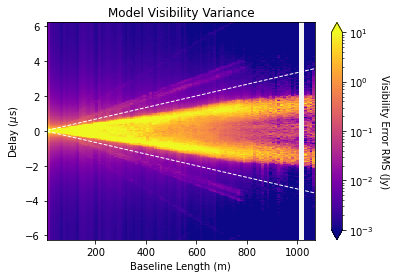

In [4]:
binned_delay_spec_diff, bin_edges = calculate_binned_rms(
    diff_fft_abs, diff_vis.uvw_array, diff_vis.Nfreqs
)
plot_delay_spectra(
    binned_delay_spec_diff**2.,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=1e-3,
    vmax=1e1,
)

In [5]:
np.shape(diff_fft_abs)

(5627, 1, 384, 1)

# Fit weighting matrix with Gaussian

In [6]:
boundary_slope = 0.6284790822752272
wedge_buffer = 0.
c = 3e8

wedge_vis_sum = 0.
wedge_vis_n = 0
for delay_ind, delay_val in enumerate(delay_array):
    wedge_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer > np.abs(delay_val)
    )[0]
    if len(wedge_bls) > 0:
        wedge_vis_sum += np.sum(diff_fft_abs[wedge_bls, 0, delay_ind, 0]**2.)
        wedge_vis_n += len(wedge_bls)

In [7]:
print(wedge_vis_sum/wedge_vis_n)

7.101176738469631


In [8]:
window_vis_sum = np.sum(diff_fft_abs**2.) - wedge_vis_sum
window_vis_n = np.size(diff_fft_abs) - wedge_vis_n
print(window_vis_sum/window_vis_n)

0.09312118661179891


In [9]:
# Confirm window average
window_vis_sum = 0.
window_vis_n = 0
for delay_ind, delay_val in enumerate(delay_array):
    window_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer <= np.abs(delay_val)
    )[0]
    if len(window_bls) > 0:
        window_vis_sum += np.sum(diff_fft_abs[window_bls, 0, delay_ind, 0]**2.)
        window_vis_n += len(window_bls)
        
print(window_vis_sum/window_vis_n)

0.09312118661179813


In [34]:
window_vis_vals = np.full(data.Nfreqs, np.nan)
wedge_buffer = 6.5e-8
for delay_ind, delay_val in enumerate(delay_array):
    window_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer <= np.abs(delay_val)
    )[0]
    if len(window_bls) > 0:
        window_vis_vals[delay_ind] = np.mean(diff_fft_abs[window_bls, 0, delay_ind, 0]**2.)

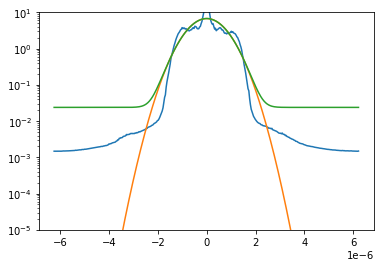

In [50]:
plt.plot(delay_array, window_vis_vals)
plt.plot(delay_array, 6.74466968e+00*np.exp(-delay_array**2/(6.63541190e-07)**2/2))
plt.plot(delay_array, 6.73642264e+00*np.exp(-delay_array**2/(6.58794760e-07)**2/2)+2.38625311e-02)
#plt.xlim([-1e-6,1e-6])
#plt.ylim([.001,300])
plt.ylim([1e-5,10])
plt.yscale("log")
plt.show()

In [41]:
def gaussian_fit_cost_func(x, delay_array, window_vis_vals):
    amp = x[0]
    sigma = x[1]
    min_val = x[2]
    
    gaussian_func = amp*np.exp(-delay_array**2/sigma**2/2) + min_val
    return np.nanmean((window_vis_vals - gaussian_func)**2)

gaussian_fit_result = scipy.optimize.minimize(
    gaussian_fit_cost_func,
    [250, 1e-6, 0],
    args=(delay_array, window_vis_vals),
    method="Powell",
)
print(gaussian_fit_result)

   direc: array([[ 1.53400936e-01, -3.11218920e-08,  4.97425380e-03],
       [ 7.48232667e-01,  6.25523159e-10, -2.12871868e-04],
       [-1.24356873e-03, -6.13563585e-10,  3.70571691e-03]])
     fun: 1.0188059453541243
 message: 'Optimization terminated successfully.'
    nfev: 274
     nit: 6
  status: 0
 success: True
       x: array([6.73642264e+00, 6.58794760e-07, 2.38625311e-02])


In [13]:
boundary_slope = 0.6284790822752272
c = 3e8
wedge_var = 7.060438044132621
window_var = 0.09310922310592183

weighting_function = np.full((data.Nbls, data.Nfreqs), window_var)
for delay_ind, delay_val in enumerate(delay_array):
    wedge_bls = np.where(
        bl_lengths * boundary_slope / c + wedge_buffer > np.abs(delay_val)
    )[0]
    if len(wedge_bls) > 0:
        weighting_function[wedge_bls, delay_ind] = wedge_var
        
# bin results
bl_lengths = np.sqrt(np.sum(data.uvw_array**2.0, axis=1))
nbins = 100
min_val = np.min(bl_lengths)
max_val = np.max(bl_lengths)
bl_bin_edges = np.linspace(min_val, max_val, num=nbins + 1)
binned_weighting = np.full([nbins, data.Nfreqs], np.nan, dtype="float")
for bin_ind in range(nbins):
    bl_inds = np.where(
        (bl_lengths > bl_bin_edges[bin_ind])
        & (bl_lengths <= bl_bin_edges[bin_ind + 1])
    )[0]
    if len(bl_inds) > 0:
        binned_weighting[bin_ind, :] = np.mean(
            weighting_function[bl_inds, :], axis=0
        )

1.2814485314840924


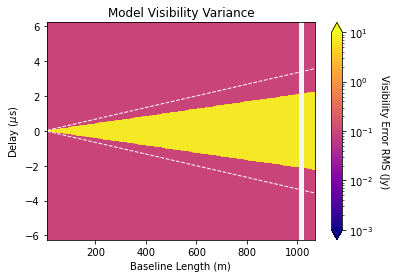

In [14]:
print(np.nanmean(np.abs(binned_delay_spec_diff**2.-binned_weighting)))
plot_delay_spectra(
    binned_weighting,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=1e-3,
    vmax=1e1,
)

1.2814485314840924


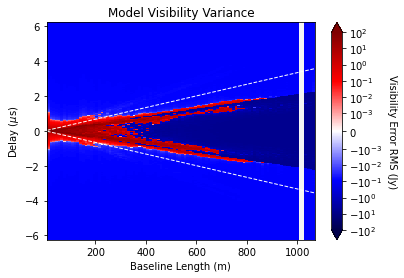

In [15]:
print(np.nanmean(np.abs(binned_delay_spec_diff**2.-binned_weighting)))
plot_delay_spectra(
    binned_delay_spec_diff**2.-binned_weighting,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=-1e2,
    vmax=1e2,
)

1.5486048099872767


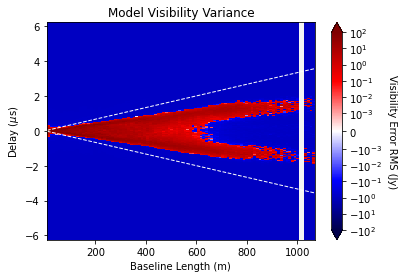

In [16]:
print(np.nanmean(np.abs(binned_delay_spec_diff**2.-np.nanmean(binned_delay_spec_diff**2.))))
plot_delay_spectra(
    binned_delay_spec_diff**2.-np.nanmean(binned_delay_spec_diff**2.),
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=-1e2,
    vmax=1e2,
)

In [17]:
#wedge_error = 3.363526708016346
#window_error_floor = 0.604286499397227
#boundary_slope = 148.58642850638304 / c
#wedge_buffer = 3.363526708016346
#gaussian_peak = 0.604286499397227
#gaussian_width = 148.58642850638304

wedge_error = 7.1
window_error_floor = 0.07
boundary_slope = 0.62 / c
wedge_buffer = 0.
gaussian_peak = 4
gaussian_width = 1e-6

fit = np.full((Nbls, Nfreqs), window_error_floor)
fit += gaussian_peak * np.exp(
    -delay_array[np.newaxis, :] ** 2.0 / (2 * gaussian_width**2.0)
)
for delay_ind, delay_val in enumerate(delay_array):
    wedge_bls = np.where(
        bl_lengths * boundary_slope + wedge_buffer > np.abs(delay_val)
    )[0]
    if len(wedge_bls) > 0:
        fit[wedge_bls, delay_ind] = wedge_error

fit_binned, bin_edges = calculate_binned_rms(
    fit[:, np.newaxis, :, np.newaxis], diff_vis.uvw_array, diff_vis.Nfreqs
)
plot_delay_spectra(
    fit_binned,
    bin_edges,
    delay_array,
    title="Model Visibility Variance",
    add_lines=[1.0],
    vmin=1e0,
    vmax=1e1,
)

NameError: name 'Nbls' is not defined